In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando o dispositivo: {device}")

Usando o dispositivo: cuda


In [6]:
# Instalação das bibliotecas necessárias (descomente se não estiverem instaladas)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install numpy pandas matplotlib pyro-ppl tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

# Configurações para os gráficos
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

/home/cordoeira/.conda/envs/CosmoPINN_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def gerar_dados_simulados(arquivo='Hz_joindata_nozero.txt'):
    """Gera um arquivo de dados simulados para H(z) baseado no modelo ΛCDM."""
    # Parâmetros cosmológicos de "verdade"
    H0_verdade = 70.0  # km/s/Mpc
    Omega_m_verdade = 0.3

    # Modelo ΛCDM teórico
    def modelo_LCMD_teorico(z, H0, Omega_m):
        Omega_l = 1.0 - Omega_m
        E_z = np.sqrt(Omega_m * (1 + z)**3 + Omega_l)
        return H0 * E_z

    # Gerar pontos de redshift (z)
    z_vals = np.linspace(0.01, 2.0, 30)
    H_vals = modelo_LCMD_teorico(z_vals, H0_verdade, Omega_m_verdade)

    # Adicionar ruído gaussiano realista (erros maiores para z mais alto)
    np.random.seed(42)
    erros = H_vals * np.random.uniform(0.05, 0.15, size=z_vals.shape)
    H_observado = H_vals + np.random.normal(0, erros)

    # Salvar em um arquivo de texto
    np.savetxt(arquivo, np.vstack([z_vals, H_observado, erros]).T,
               header='z_redshift H(z)_observado erro_H(z)', fmt='%.4f')
    print(f"Arquivo '{arquivo}' gerado com sucesso.")

# Gerar os dados (ou use o seu arquivo 'Hz_joindata_nozero.txt')
# Se for usar seu arquivo, pode comentar a linha abaixo
gerar_dados_simulados()

# --- CORREÇÃO APLICADA AQUI ---
# Define os nomes esperados para as colunas
nomes_colunas = ['z_redshift', 'H(z)_observado', 'erro_H(z)']

# Carregar os dados com Pandas, especificando os nomes das colunas
# Substitua 'Hz_joindata_nozero.txt' pelo seu arquivo 'Hz_joindata_nozero.txt' se preferir
df_dados = pd.read_csv(
    'Hz_joindata_nozero.txt',
    delim_whitespace=True,
    comment='#',
    names=nomes_colunas
)

# Dica de depuração: verificar as colunas do DataFrame
print("\nColunas do DataFrame carregado:", df_dados.columns.tolist())

# Converter para tensores PyTorch
z_obs = torch.tensor(df_dados['z_redshift'].values, dtype=torch.float32).view(-1, 1)
H_obs = torch.tensor(df_dados['H(z)_observado'].values, dtype=torch.float32).view(-1, 1)
sigma_H_obs = torch.tensor(df_dados['erro_H(z)'].values, dtype=torch.float32).view(-1, 1)

print("\nDados carregados com sucesso:")
print(df_dados.head())

Arquivo 'Hz_joindata_nozero.txt' gerado com sucesso.

Colunas do DataFrame carregado: ['z_redshift', 'H(z)_observado', 'erro_H(z)']

Dados carregados com sucesso:
   z_redshift  H(z)_observado  erro_H(z)
0      0.0100         63.2394     6.1495
1      0.0786         76.5855    10.5361
2      0.1472         69.6020     9.2602
3      0.2159         75.4272     8.5612
4      0.2845         77.7096     5.3074


/tmp/ipykernel_2504620/2282653975.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_dados = pd.read_csv(


In [11]:
# Verifica se a GPU com CUDA está disponível e define o dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo selecionado: {device}")
if device == "cuda":
    print(f"Nome da GPU: {torch.cuda.get_device_name(0)}")

Dispositivo selecionado: cuda
Nome da GPU: NVIDIA GeForce RTX 3060


In [12]:
class EmuladorH(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=1):
        super(EmuladorH, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.network(x)

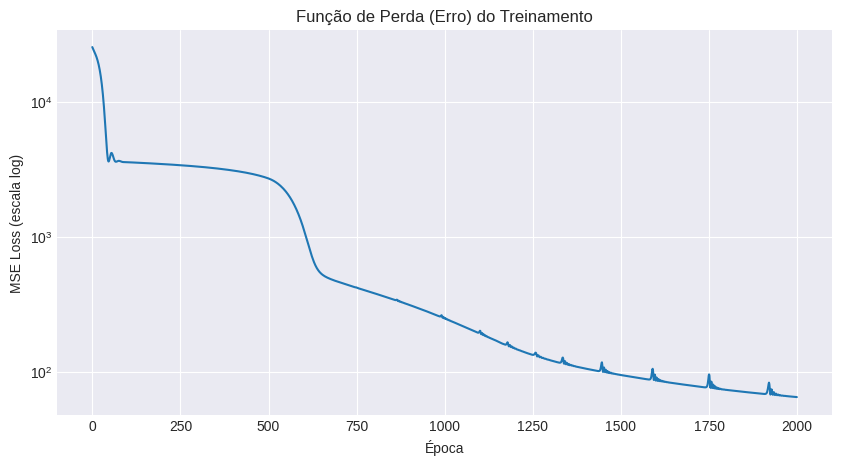

Treinando o Emulador: 100%|██████████| 2000/2000 [00:13<00:00, 149.04it/s, MSE Loss=64.8553]


Treinamento concluído!


In [14]:
### Passo 5: Treinamento do Emulador na GPU

# --- MUDANÇA APLICADA AQUI ---
from tqdm import tqdm # Usando a versão padrão de texto
from IPython import display # Necessário para a atualização do gráfico

def treinar_emulador(num_epocas=2000, num_amostras_treino=50000):
    # Gerar dados de treinamento sintéticos a partir do modelo teórico
    H0_range = [60, 80]
    Omega_m_range = [0.1, 0.5]
    z_range = [0, 2.5]

    H0_treino = torch.rand(num_amostras_treino, 1) * (H0_range[1] - H0_range[0]) + H0_range[0]
    Omega_m_treino = torch.rand(num_amostras_treino, 1) * (Omega_m_range[1] - Omega_m_range[0]) + Omega_m_range[0]
    z_treino = torch.rand(num_amostras_treino, 1) * (z_range[1] - z_range[0]) + z_range[0]

    # Função do modelo teórico ΛCDM em PyTorch
    def modelo_LCMD_teorico_torch(z, H0, Omega_m):
        Omega_l = 1.0 - Omega_m
        E_z = torch.sqrt(Omega_m * (1 + z)**3 + Omega_l)
        return H0 * E_z

    H_teorico = modelo_LCMD_teorico_torch(z_treino, H0_treino, Omega_m_treino)
    
    # Montar o tensor de entrada
    X_treino = torch.cat([z_treino, H0_treino, Omega_m_treino], dim=1)

    # Instanciar modelo, otimizador e função de perda
    emulador = EmuladorH().to(device)
    optimizer = optim.Adam(emulador.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Mover dados para a GPU
    X_treino = X_treino.to(device)
    H_teorico = H_teorico.to(device)
    
    # Loop de treinamento
    losses = []
    pbar = tqdm(range(num_epocas), desc="Treinando o Emulador")
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    for epoch in pbar:
        emulador.train()
        
        # Forward pass
        H_pred = emulador(X_treino)
        loss = criterion(H_pred, H_teorico)
        
        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pbar.set_postfix({"MSE Loss": f"{loss.item():.4f}"})

        # Atualizar gráfico em tempo real
        if (epoch + 1) % 50 == 0:
            ax.clear()
            ax.plot(losses)
            ax.set_yscale('log')
            ax.set_title("Função de Perda (Erro) do Treinamento")
            ax.set_xlabel("Época")
            ax.set_ylabel("MSE Loss (escala log)")
            ax.grid(True)
            display.clear_output(wait=True)
            display.display(fig)

    plt.close(fig)
    print("\nTreinamento concluído!")
    return emulador.to("cpu") # Mover para a CPU para inferência com Pyro

# Treinar o emulador
emulador_treinado = treinar_emulador()

In [15]:
def modelo_bayesiano_com_emulador(z_data, H_data, sigma_data):
    # 1. Definir Priors para os parâmetros
    # Amostra um valor para H0 de uma distribuição uniforme entre 60 e 80
    H0 = pyro.sample("H0", dist.Uniform(60.0, 80.0))
    # Amostra um valor para Omega_m de uma distribuição uniforme entre 0.1 e 0.5
    Omega_m = pyro.sample("Omega_m", dist.Uniform(0.1, 0.5))

    # 2. Avaliar o modelo com os parâmetros amostrados
    # Expandir os parâmetros para terem o mesmo tamanho dos dados de z
    H0_tensor = H0.expand(z_data.shape[0], 1)
    Omega_m_tensor = Omega_m.expand(z_data.shape[0], 1)
    
    # Montar a entrada para o emulador
    emulador_input = torch.cat([z_data, H0_tensor, Omega_m_tensor], dim=1)
    
    # Obter a previsão do emulador
    H_pred = emulador_treinado(emulador_input).squeeze()

    # 3. Definir a Likelihood (Verossimilhança)
    # Comparamos os dados observados com as previsões do modelo,
    # assumindo que os erros são normalmente distribuídos.
    with pyro.plate("data_plate", size=len(H_data)):
        pyro.sample("obs", dist.Normal(H_pred, sigma_data.squeeze()), obs=H_data.squeeze())

# Limpar o armazenamento de parâmetros do Pyro antes de executar
pyro.clear_param_store()


In [19]:
import torch.multiprocessing as mp

# --- CORREÇÃO APLICADA AQUI ---
# Define o método de início do multiprocessing para 'spawn'
# Isso é necessário para evitar erros com autograd e fork em num_chains > 1
try:
    mp.set_start_method('spawn', force=True)
    print("Método de início do multiprocessing definido como 'spawn'.")
except RuntimeError:
    pass # Evita erro se já foi definido

# Configurar o kernel NUTS
kernel = NUTS(modelo_bayesiano_com_emulador, adapt_step_size=True)

# Configurar e executar o MCMC
mcmc = MCMC(kernel,
            num_samples=2000,
            warmup_steps=1000,
            num_chains=2, # Agora podemos usar múltiplas cadeias sem erro
            )

# Executar o amostrador
mcmc.run(z_obs, H_obs, sigma_H_obs)

print("\nAmostragem MCMC concluída!")

Método de início do multiprocessing definido como 'spawn'.


Warmup [1]:   0%|          | 0/3000 [00:00, ?it/s]Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "/home/cordoeira/.conda/envs/CosmoPINN_env/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/home/cordoeira/.conda/envs/CosmoPINN_env/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
        exitcode = _main(fd, parent_sentinel)exitcode = _main(fd, parent_sentinel)

  File "/home/cordoeira/.conda/envs/CosmoPINN_env/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
  File "/home/cordoeira/.conda/envs/CosmoPINN_env/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
        self = reduction.pickle.load(from_parent)self = reduction.pickle.load(from_parent)

AttributeErrorAttributeError: : Can't get attribute 'modelo_bayesiano_com_emulador' on <module '__main__' (built-in)>Can't get attribute 'modelo_bayesiano_com_emulador' on <mod

KeyboardInterrupt: 

In [ ]:
# 1. Obter o resumo estatístico e exibir como DataFrame
summary_dict = mcmc.summary(prob=0.95)
summary_df = pd.DataFrame(summary_dict).T
print("Relatório de Inferência Bayesiana (Intervalos de Confiança de 95%):")
display(summary_df)

# Extrair as amostras
samples = mcmc.get_samples()
H0_samples = samples['H0'].numpy()
Omega_m_samples = samples['Omega_m'].numpy()

# 2. Criar os gráficos de resultados
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Resultados da Inferência MCMC", fontsize=16)

# Histograma para H0
axes[0, 0].hist(H0_samples, bins=30, density=True, alpha=0.7, label="Posterior de H0")
axes[0, 0].set_title("Distribuição Posterior de H$_0$")
axes[0, 0].set_xlabel("H$_0$ (km/s/Mpc)")
axes[0, 0].axvline(H0_samples.mean(), color='r', linestyle='--', label=f'Média: {H0_samples.mean():.2f}')
axes[0, 0].legend()

# Histograma para Omega_m
axes[0, 1].hist(Omega_m_samples, bins=30, density=True, alpha=0.7, label="Posterior de Ω_m")
axes[0, 1].set_title("Distribuição Posterior de $\Omega_m$")
axes[0, 1].set_xlabel("$\Omega_m$")
axes[0, 1].axvline(Omega_m_samples.mean(), color='r', linestyle='--', label=f'Média: {Omega_m_samples.mean():.2f}')
axes[0, 1].legend()

# Gráfico de Trajetória (Trace plot) para H0
axes[1, 0].plot(H0_samples, alpha=0.7)
axes[1, 0].set_title("Trace Plot de H$_0$")
axes[1, 0].set_xlabel("Amostra MCMC")

# Gráfico de Trajetória (Trace plot) para Omega_m
axes[1, 1].plot(Omega_m_samples, alpha=0.7)
axes[1, 1].set_title("Trace Plot de $\Omega_m$")
axes[1, 1].set_xlabel("Amostra MCMC")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. Gráfico de comparação final: Dados vs. Modelo ajustado
z_plot = torch.linspace(0, 2.5, 100).view(-1, 1)
H0_fit = torch.tensor(H0_samples.mean()).expand(100, 1)
Omega_m_fit = torch.tensor(Omega_m_samples.mean()).expand(100, 1)
emulador_input_plot = torch.cat([z_plot, H0_fit, Omega_m_fit], dim=1)

with torch.no_grad():
    emulador_treinado.eval()
    H_fit_pred = emulador_treinado(emulador_input_plot)

plt.figure(figsize=(10, 7))
plt.errorbar(df_dados['z_redshift'], df_dados['H(z)_observado'], yerr=df_dados['erro_H(z)'],
             fmt='o', color='black', label='Dados Observacionais', capsize=3)
plt.plot(z_plot.numpy(), H_fit_pred.numpy(), color='crimson', linewidth=2,
         label=f'Modelo Ajustado (H$_0$={H0_samples.mean():.2f}, $\Omega_m$={Omega_m_samples.mean():.2f})')
plt.title("Comparação: Dados vs. Modelo com Parâmetros Inferidos", fontsize=14)
plt.xlabel("Redshift (z)", fontsize=12)
plt.ylabel("H(z) [km/s/Mpc]", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()